<a href="https://colab.research.google.com/github/pjprathmesh/Gesture-Control-Google-T-rex-Game/blob/master/hand_gesture_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Aug 11 12:00:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Input,BatchNormalization,Input
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
df_train=pd.read_csv("/content/drive/My Drive/sign_mnist_train.csv")
df_test=pd.read_csv("/content/drive/My Drive/sign_mnist_test.csv")
y_train=df_train["label"].values.astype(np.int64)
y_test=df_test["label"].values.astype(np.int64)
xx=df_train.iloc[:,1:].values.reshape(27455, 28, 28,1)/255.
factor = 35/28
xt=df_test.iloc[:,1:].values.reshape(7172, 28, 28,1)/255.

X_train=imgs_out = ndi.zoom( xx,(1, factor, factor, 1), order=2)#/255.
X_test= ndi.zoom(xt,(1, factor, factor, 1), order=2)#/255.



4


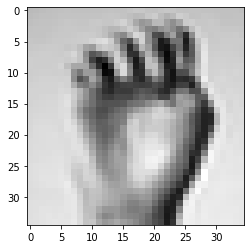

In [ ]:
from keras.layers import MaxPool2D
plt.imshow(X_test[101,...,-1],cmap="gray")
print(y_test[101])
plt.show()
y_train.shape
dataset=tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(100)#.shuffle(100, reshuffle_each_iteration=True)

In [ ]:
class MyDence(tf.keras.layers.Layer):
  def __init__(self,num_outputs):
    super(MyDence,self).__init__()
    self.out=num_outputs
    
  def get_config(self):
    cfg = super().get_config()
    return cfg

  def build(self,input_shape):
    self.kernel=self.add_weight(shape=[self.out,input_shape[-1]],initializer='glorot_normal', trainable=True,)
    # self.kernel=tf.Variable(tf.random.normal([self.out,input_shape[-1]]),i)

  def call(self,input):
    xw=tf.matmul(input,tf.transpose(self.kernel))
    w_norm = tf.norm(self.kernel, axis = 1) + 1e-8
    logits = xw/w_norm
    return logits
layer=MyDence(25) 

In [ ]:
num_category = 25

inp=Input((35,35,1))
x=Conv2D(filters=64,kernel_size=(5,5),activation="relu",)(inp)
x=MaxPool2D( pool_size=(1,1))(x)


x=Conv2D(filters=128,kernel_size=(5,5),activation="relu",)(x)
x=MaxPool2D( pool_size=(2,2))(x)



x=Conv2D(filters=256,kernel_size=(7,7),activation="relu",)(x)
x=MaxPool2D( pool_size=(2,2))(x)




x=Flatten()(x)

x=Dense(128,activation="relu",)(x)

x1=Dense(25,use_bias=False,)(x)
x=layer(x1)

model=Model(inp,[x,x1])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 35, 35, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 31, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         1605888   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)        

In [ ]:
from sklearn.metrics import accuracy_score

epochs = 400
eps = 1e-8
batch_size = 100
scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer =tf.keras.optimizers.Adam(0.00005)

for epoch in range(epochs):
  for step, (x_batch_train, y) in enumerate(dataset):
    with tf.GradientTape() as tape:

            o = model(x_batch_train, training=True)
            logits=o[0]
            x=o[1]
    
            
            ordinal = tf.constant(list(range(0, y.get_shape()[0])), tf.int64)
            ordinal_y = tf.stack([ordinal, y], axis = 1)
            x_norm = tf.norm(x, axis = 1) + eps
            sel_logits = tf.gather_nd(logits, ordinal_y)
            cos_th = sel_logits/x_norm

            cos_th2 = tf.square(cos_th)
            cos_th4 = tf.pow(cos_th, 4)
            sign0 = tf.sign(cos_th)
            sign3 = tf.multiply(tf.sign(2*cos_th2 - 1), sign0)
            sign4 = 2*sign0 + sign3 - 3
            res = sign3*(8*cos_th4 - 8*cos_th2 + 1) + sign4
            scaled_logits = tf.multiply(res, x_norm)
            
            comb_logits_diff = tf.add(logits, tf.scatter_nd(ordinal_y, tf.subtract(scaled_logits, sel_logits), logits.get_shape()))
            
            loss_value =scce(y, comb_logits_diff)
            # print(logits,res)
            # print(loss_value)
           
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
          



  if epoch%1==0:
 
    logits = model.predict(X_test,)  

    
   
   
    soft=tf.nn.softmax(logits[0])
    loss_value =scce(y_test, logits[0]).numpy()
    out=tf.math.argmax(soft,axis=1)
    test=accuracy_score(y_test, out)
    print("test acc "+str(test)+" test loss "+str(loss_value))
  
            
            




    
  
  print("epoch : "+ str(epoch)+" loss : "+str(loss_value))
  print()

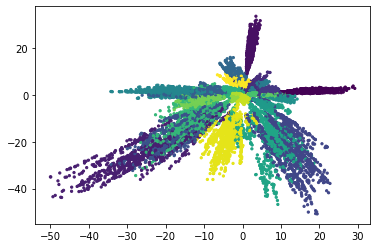

In [ ]:
model2=Model(model.input,model.layers[-1].output)
h=model2.predict(X_train[:])
plt.scatter(h[:,0],h[:,1],c=y_train,s=5)